# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Floor & Ceiling

Regime calculation using floor and ceiling, while conceptually simple, is computationally more involved. Now that we have swings, we can move to the next step: **regime definition**.

**What is the classic definition of the bull and bear market?**

The classic definition of higher highs, higher lows for a bull, and lower lows, lower highs, while intellectually satisfying has unfortunately low statistical validity. Markets are noisy. Swing highs and lows are like stars: they are rarely aligned.

The classic definition of a bear market is: price drops -20% from the peak. Bear market ends when price takes out the old peak. It sounds nice, except no-one uses it in practice. No-one waited for new highs in 2018 to declare that the S&P500 was in a bull market. People started talking about a bull market when there was substantial evidence that the low in March 2009 was the bottom. 


**What is a floor and ceiling method?**

The floor and ceiling method is much closer to people's actual perception of when bull and bear start. We intuitively know that a bull market is underway, when new lows fail to penetrate the bottom and rally upward. Conversely, we intuitively know that a bear market has started when new highs fail to take out the peak. 

The floor ceiling method introduces a statistical quantification of the distance between the peak/bottom and subsequent swings. The objective is twofold:

1. Identify the earliest of a regime change: Bull ends on a high note, Bear ends at a low point
2. Probabilistic quantification

Thus, floor/ceiling regime does not switch back and forth in sideways markets. Floor/ceiling is more stable than moving average crossover and does not suffer as much drawdowns as breakouts.

**But how can you identify a change in trend?**
1. *Percentage points:*

The start of the bear market could be calculated using percentage points, something like 10-20% from the top. Whilst intellectually comfortable, it is also disrespectful of the markets. Stocks do not have the same volatility signature. Then, what are other alternatives?

2. *Volatility:*

It is, therefore, preferable to restate distance in units of volatility. This could be: average true range, realised vol, Garman-Klass, Zhang-Yang etc. A simple but robust way is to calculate is if the current value is 1.5 standard deviation away from the ceiling, then we mark it as the start of the bear market and start the regime change. Similarly, for the bull market. Here, we use a rolling 3 month standard deviation. 3 months out is where the most liquid duration in the vol space.

After completing this notebook, you will be able to calculate the regime using floor and ceiling method.

This notebook is divided into the following key parts.
1. [Swings](#swings)
2. [Volatility calculation](#volatility)
3. [Regime calculation](#regime)
4. [Perform the adjustment](#adjustments)
5. [Moving average](#moving_average)
6. [Plotting](#plotting)
7. [Summary of the algorithm to identify ceilings and floor](#algo) 
8. [Create a function](#function)

## Import libraries

In [17]:
# Data analysis and manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# Calculates swing highs and lows
from scipy.signal import *
from scipy.signal import argrelextrema

# Plotting
import matplotlib.pyplot as plt
# To avoid warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# The short_selling library has all the functions defined in the previous notebooks
import sys
sys.path.append("..")
from data_modules.short_selling import graph_regime_fc
from data_modules.short_selling import swings
from data_modules.short_selling import sma
from data_modules.short_selling import read_data

## Import data

The files name `Jan_2010_to_Jan_2019_Rebased_Series` contains the rebased series data.

In [18]:
# Data is stored in the directory 'data_modules'
relative_path = "../data_modules/"
# Reads and imports the rebased series using the function 'read_csv'
data = pd.read_csv(relative_path + 'Jan_2010_to_Jan_2019_Rebased_Series.csv', index_col=0, parse_dates=True)
# Set index in datetime format
data.index = pd.to_datetime(data.index)
# Returns the first two rows of the dataset
data.head(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,relative_close,rebased_open,rebased_high,rebased_low,rebased_close
Date,,,,,,,,,,,,,,,
2010-01-04,15.24,15.75,15.12,15.69,0.62,113.33,70.35,0.22,0.22,0.21,0.22,15.24,15.75,15.12,15.69
2010-01-05,15.74,16.21,15.70,16.20,0.63,113.63,71.06,0.22,0.23,0.22,0.23,15.58,16.05,15.54,16.04


<a id='swings'></a> 
## Calculate swings
We calculate the swings using the `swings` function from the short_selling library.
      
      '''
      df: data
      hi: rebased high price of the data
      lo: rebased low price of the data
      argel window: by default, taken as 20
      '''

In [19]:
# Swing calculation
data = swings(df=data, high='rebased_high', low='rebased_low', argrel_window=20)
data.tail(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,relative_close,rebased_open,rebased_high,rebased_low,rebased_close,srebased_low,srebased_high
Date,,,,,,,,,,,,,,,,,
2018-12-31,24.57,24.97,24.37,24.64,0.79,249.92,196.32,0.13,0.13,0.12,0.13,8.80,8.95,8.73,8.83,NaN,NaN
2019-01-02,24.08,25.14,24.01,24.96,0.80,250.18,200.63,0.12,0.13,0.12,0.12,8.44,8.82,8.42,8.75,NaN,NaN


In [20]:
# Copy swing lows and highs to a smaller dataframe called regime
regime = data[(data['srebased_low'] > 0) | (data['srebased_high'] > 0)][[
    'rebased_close', 'srebased_low', 'srebased_high']].copy()
regime.tail(2)

,rebased_close,srebased_low,srebased_high
Date,,,
2018-07-30,10.33,NaN,10.38
2018-12-10,8.28,8.13,NaN


<a id='volatility'></a>
## Volatility calculation

In [21]:
# Calculate volatility from main dataframe and populate regime dataframe
regime['stdev'] = round(data['rebased_close'].rolling(window=63, min_periods=63).std(0), 2)
regime.tail(2)

,rebased_close,srebased_low,srebased_high,stdev
Date,,,,
2018-07-30,10.33,NaN,10.38,0.42
2018-12-10,8.28,8.13,NaN,0.31


In [22]:
# Instantiate columns based on absolute and relative series
# Relative series (Check the first letter of 'close')
close = 'rebased_close'
if str(close)[0] == 'r':
    regime_cols = ['r_floor', 'r_ceiling', 'r_regime_change',
                   'r_regime_floorceiling', 'r_floorceiling', 'r_regime_breakout']
# Absolute series
else:
    regime_cols = ['floor', 'ceiling', 'regime_change',
                   'regime_floorceiling', 'floorceiling', 'regime_breakout']

In [23]:
# Instantiate columns by concatenation
# Concatenate regime dataframe with a temporary dataframe with same index initialised at NaN
regime = pd.concat([regime, pd.DataFrame(np.nan, index=regime.index, columns=regime_cols)], axis=1)
regime.tail(2)

,rebased_close,srebased_low,srebased_high,stdev,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout
Date,,,,,,,,,,
2018-07-30,10.33,NaN,10.38,0.42,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-10,8.28,8.13,NaN,0.31,NaN,NaN,NaN,NaN,NaN,NaN


<a id='regime'></a>
## Calculate regime

We loop through the swing to find the floor and the ceiling. First, we look for the floor and once, we find the floor, we look for the ceiling. The swings at which both the floors and the ceilings are found are called "base". This is where the regime effectively changes.

We start the for loop at the first swing and iterate over the length of the dataframe, regime. We run the for loop over two conditions:
1. When we ignore swing lows or only consider swing highs
2. When we ignore swing highs or only consider swing lows

**1. When we ignore swing lows**

1. We are looking for the highest high of the range starting from the floor to the current swing high. 
2. We perform a distance test, if the test is passed, we assign the top value to the ceiling and index. 
3. And, if the current regime is not bearish, we record a regime change and assign bearish -1 to the regime.

Once we have found a ceiling, we start looking for a floor.

**2. When we ignore swing highs**

Similarly, we perform the same steps but to find the floor in this case. Again, we perform a distance test, if the test is passed, we assign the bottom value to the floor and index. And, if the current regime is not bullish, we record a regime change and assign bullish 1 to the regime.

In [24]:
# Set floor and ceiling range to 1st swing
floor_ix = regime.index[0]
ceiling_ix = regime.index[0]

# Standard deviation threshold to detect the change
threshold = 1.5

# current_regime 0: Starting value 1: Bullish -1: Bearish
current_regime = 0

for i in range(1, len(regime)):

    # Ignores swing lows
    if regime['srebased_high'][i] > 0:
        # Find the highest high (srebased_high) from range floor_ix to current value
        top = regime[floor_ix:regime.index[i]]['srebased_high'].max()
        top_index = regime[floor_ix:regime.index[i]]['srebased_high'].idxmax()
        
        # (srebased_high - top) / stdev
        ceiling_test = round((regime['srebased_high'][i]-top)/regime['stdev'][i], 1)
        
        # Check if current value is 1.5 x standard devaition away from the top value
        if ceiling_test <= -threshold:
            
            # Set ceiling = top and celing_ix to index (id)
            ceiling = top
            ceiling_ix = top_index
            
            # Assign ceiling
            regime.loc[ceiling_ix, 'r_ceilling'] = ceiling

            # If the current_regime is not bearish
            # The condition will satisfy 
            # And we will change the regime to bearish and set current_regime to -1            
            if current_regime != -1:
                rg_change_ix = regime['srebased_high'].index[i]
                _rg_change = regime['srebased_high'][i]
                
                # Prints where/n ceiling found
                regime.loc[rg_change_ix, 'r_regime_change'] = _rg_change
                # Regime change
                regime.loc[rg_change_ix, 'r_regime_floorceiling'] = -1

                # Test for floor/ceiling breakout
                regime.loc[rg_change_ix, 'r_floorceiling'] = ceiling
                current_regime = -1


    # Ignores swing highs
    if regime['srebased_low'][i] > 0:
        # Lowest swing low from ceiling
        bottom = regime[ceiling_ix:regime.index[i]]['srebased_low'].min()
        bottom_index = regime[ceiling_ix:regime.index[i]]['srebased_low'].idxmin()

        floor_test = round((regime['srebased_low'][i]-bottom)/regime['stdev'][i], 1)

        if floor_test >= threshold:
            floor = bottom
            floor_ix = bottom_index
            regime.loc[floor_ix, 'r_floor'] = floor

            if current_regime != 1:
                rg_change_ix = regime['srebased_low'].index[i]
                _rg_change = regime['srebased_low'][i]
                
                # Prints where/n floor found
                regime.loc[rg_change_ix, 'r_regime_change'] = _rg_change
                # regime change
                regime.loc[rg_change_ix, 'r_regime_floorceiling'] = 1
                # Test for floor/ceiling breakout
                regime.loc[rg_change_ix, 'r_floorceiling'] = floor

                current_regime = 1

<a id='adjustments'></a>
## Perform adjustments

We have identified the floor and the ceiling across the dataset. Next, we need to handle exceptions. Sometimes, the market rallies beyond the ceiling or drops below the floor without warning. If price takes out the ceiling, it is bullish and vice versa when it penetrates the floor. We, therefore, need to adjust.

**Logic for exceptions**

1. If price crosses over the old peak in a bear phase, regime turns bullish and vice versa when price crosses under bottom in a bull phase.
2. We calculate cumulative max and min and group them by floor ceiling (unique identifier)
3. We assign by regime: 
    1. Bull: base > fc, assign close_min to test breakdown and regime switch to Bear
    2. Bear: base < fc, assign close_max to test breakout and regime switch to Bull
4. We calculate the sign of the subtraction with fc
5. If <0:
    1. change base to old floor/ceiling
    2. change regime

In [25]:
# Join regime to data using the function 'df1.join((df2), on='Date', how='outer')
data = data.join(regime[regime_cols], on='Date', how='outer')
data.head(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,...,rebased_low,rebased_close,srebased_low,srebased_high,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,15.24,15.75,15.12,15.69,0.62,113.33,70.35,0.22,0.22,0.21,...,15.12,15.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,15.74,16.21,15.70,16.20,0.63,113.63,71.06,0.22,0.23,0.22,...,15.54,16.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using `fillna(0)`, forward fill `'regime_floorceiling', 'regime_change' and 'floorceiling'`.

In [26]:
# Forward fill 'regime_floorceiling','regime_change' and 'floorceiling'
c=['r_regime_floorceiling', 'r_regime_change', 'r_floorceiling']
data[c] = data[c].fillna(method='ffill').fillna(0)

Test for regime change, breakout-breakdown occurs if price crosses floor/ceiling

In [27]:
# Look for highest close for every floor/ceiling
close_max = data.groupby(['r_floorceiling'])['rebased_close'].cummax()
# Look for lowest close for every floor/ceiling
close_min = data.groupby(['r_floorceiling'])['rebased_close'].cummin()


Assign the lowest close for regime bull and highest close for regime bear

In [28]:
rgme_close = np.where(data['r_floorceiling'] < data['r_regime_change'], close_min,
                      np.where(data['r_floorceiling'] > data['r_regime_change'], close_max, 0))

In [29]:
# Subtract from floor/ceiling & replace nan with 0
data['r_regime_breakout'] = (rgme_close - data['r_floorceiling']).fillna(0)
# If sign == -1 : bull breakout or bear breakdown
data['r_regime_breakout'] = np.sign(data['r_regime_breakout'])
# Regime change
data['r_regime_change'] = np.where(np.sign(
    data['r_regime_floorceiling']*data['r_regime_breakout']) == -1, 
                                   data['r_floorceiling'], data['r_regime_change'])
# Re-assign floorceiling
data['r_regime_floorceiling'] = np.where(np.sign(
    data['r_regime_floorceiling']*data['r_regime_breakout']) == -1, 
                                         data['r_regime_breakout'], data['r_regime_floorceiling'])

# Returns the top two rows of dataset
data.head(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,...,rebased_low,rebased_close,srebased_low,srebased_high,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,15.24,15.75,15.12,15.69,0.62,113.33,70.35,0.22,0.22,0.21,...,15.12,15.69,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2010-01-05,15.74,16.21,15.70,16.20,0.63,113.63,71.06,0.22,0.23,0.22,...,15.54,16.04,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


<a id='moving_average'></a>
## Moving average
We calculate short term and mid-term moving average using the functions from the short_selling library.

      '''
      df: data
      price: rebased close price of the data
      ma_per: moving average period, short term and mid-term
      min_per: by default, taken as 1
      '''

In [30]:
# Declare variables
short_term = 50
mid_term = 200
min_per = 1

# Calculate short term moving average, short_term_ma
data['short_term_ma'] = sma(df=data, price='rebased_close',
                            ma_per=short_term, min_per=min_per, decimals=2)
# Calculate mid term moving average, mid_term_ma
data['mid_term_ma'] = sma(df=data, price='rebased_close',
                          ma_per=mid_term, min_per=min_per, decimals=2)

# Returns the bottom two rows of the dataset
data.tail(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,...,srebased_low,srebased_high,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout,short_term_ma,mid_term_ma
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,24.57,24.97,24.37,24.64,0.79,249.92,196.32,0.13,0.13,0.12,...,NaN,NaN,NaN,NaN,10.38,-1.0,11.94,-1.0,8.98,9.91
2019-01-02,24.08,25.14,24.01,24.96,0.80,250.18,200.63,0.12,0.13,0.12,...,NaN,NaN,NaN,NaN,10.38,-1.0,11.94,-1.0,8.97,9.90


<a id='plotting'></a>
## Plotting

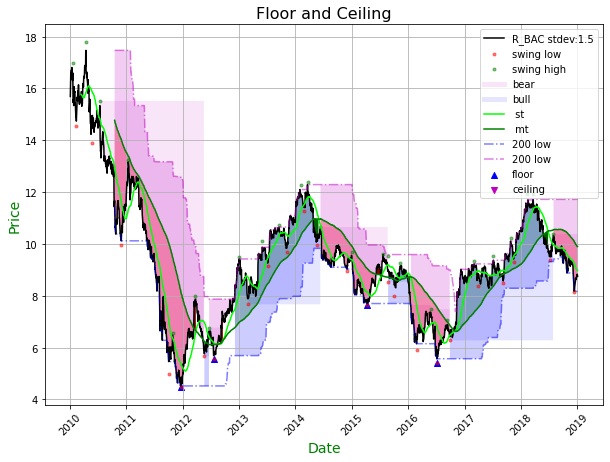

In [31]:
# Plot the graph for relative series
graph_regime_fc(ticker='r_'+'BAC', df=data, y='rebased_close', th=1.5, sl='srebased_low', sh='srebased_high',
                clg='r_ceiling', flr='r_floor', bs='r_regime_change', rg='r_regime_floorceiling', 
                st=data['short_term_ma'], mt=data['mid_term_ma'], bo=200)

<a id='algo'></a>
## Summary of the algorithm to identify ceilings and floor

1. You begin with already computed low and high swings. 
2. You calculate the volatility in terms of the rolling standard deviation to be able to quantify the change in trend.
3. This is done by iterating over the high swings and finding the highest swing from the first/index date uptil the current iteration. 
4. For every high swing, you calculate the drop from the maximum high swing (until that point) in terms of standard deviation. If the drop is more than a threshold of 1.5 standard deviations (rolling), then this max swing high is set as the ceiling from which the drop has happened. It is set only if an existing ceiling hasn't been found in the previous iterations. It can, however, be set after a floor has been identified previously. 
5. You also set an indicator for the market regime every time a drop from the ceiling is identified. It is set as -1 (bullish) after a drop from a ceiling is identified. 
6. Similarly, you iterate over the low swings and set the floor whenever a low swing is 1.5 standard deviations above the minimum swing low until that point. The floor is set only if an existing floor hasn't be set. It can, however, be set after a ceiling has been identified. 
7. You also set an indicator for the market regime every time a surge from the floor is identified. It is set as 1 (bullish) after a surge from the floor is identified.
8. After you have identified the floor and the ceiling across the dataset, you need to handle exceptions. You do this by checking if there is a price breakout above the ceiling (bullish) or a breakdown below the identified floors (bearish). 
9. This is done by first finding the cumulative max and min close corresponding to each floor and ceiling. This is then set as the regime close depending on the regime. If the regime is bullish, the cumulative min close is used. If the regime is bearish, the cumulative max close is used. 
10. If the cumulative max close is above the ceiling it is a breakout. If the cumulative min close is above the ceiling it is also considered a breakout.
11. If the breakout is positive i.e the ceiling is breached but the regime is bearish then the regime is set to bullish. Similarly, if the breakout is negative i.e the floor is breached but the regime is bullish then the regime is set to bearish.

<a id='function'></a>
##  Creating a relative floor ceiling function

The algorithm above can be put down together by creating a relative floorceiling function, 'regime_fc'. Let's learn how to calculate a relative floorceiling function.

        '''
        df: swings dataframe
        close: close price of the dataframe
        swing_low: swing_lows
        swing_high: swing_highs
        threshold: 1.5, default value
        decimals: Rounding decimals,2
        t_dev: 63
         '''
Note: The function created below will be stored in a library, short_selling which will be a part of the downloadables for your better understanding and use.

In [32]:
def regime_fc(df, close, swing_low, swing_high, threshold, t_dev, decimals):
    # 1. copy swing lows and highs to a smaller df called regime
    regime = df[(df[swing_low] > 0) | (df[swing_high] > 0)
                ][[close, swing_low, swing_high]].copy()

    # 2. calculate volatility from main df and populate regime df
    stdev = 'stdev'
    regime[stdev] = rolling_stdev(
        df=df, price=close, t_dev=t_dev, min_per=1, decimals=decimals)

    # 3. Variables declaration
    floor_ix, ceiling_ix, floor_test, ceiling_test = [], [], [], []

    ceiling_found = False
    floor_found = False

    # 4.  instantiate columns based on absolute or relative series
    if str(close)[0] == 'r':  # a) test the first letter of the close input variable
        # if 1st letter =='r', relative series, add 'r_' prefix
        regime_cols = ['r_floor', 'r_ceiling', 'r_regime_change',
                       'r_regime_floorceiling', 'r_floorceiling', 'r_regime_breakout']
    else:  # absolute series
        regime_cols = ['floor', 'ceiling', 'regime_change',
                       'regime_floorceiling', 'floorceiling', 'regime_breakout']

    # b) instantiate columns by concatenation
    regime = pd.concat([regime,  # existing df
                        # temporary df with same index, regime columns initialised at nan
                        pd.DataFrame(np.nan, index=regime.index, columns=regime_cols)],  # temp df
                       axis=1)  # along the vertical axis

    # c) column variables names instantiation via a list comprehension
    floor, ceiling, regime_change, regime_floorceiling, floorceiling, regime_breakout = [
        list(regime_cols)[n] for n in range(len(regime_cols))]

    # 5. Range initialisation to 1st swing
    floor_ix = regime.index[0]
    ceiling_ix = regime.index[0]

    # 6. Loop through swings
    for i in range(1, len(regime)):

        if regime[swing_high][i] > 0:  # ignores swing lows
            # highest swing high from range[floor_ix:swing[i]]
            top = regime[floor_ix:regime.index[i]][swing_high].max()
            ceiling_test = round(
                (regime[swing_high][i]-top)/regime[stdev][i], 1)  # test vs highest

            if ceiling_test <= -threshold:  # if swing <= top - x * stdev
                ceiling = regime[floor_ix:regime.index[i]
                                 ][swing_high].max()  # ceiling = top
                ceiling_ix = regime[floor_ix:regime.index[i]
                                    ][swing_high].idxmax()  # ceiling index
                regime.loc[ceiling_ix, ceiling] = ceiling  # assign ceiling

                if ceiling_found == False:  # test met == ceiling found
                    rg_chg_ix = regime[swing_high].index[i]
                    _rg_chg = regime[swing_high][i]
                    # prints where/n ceiling found
                    regime.loc[rg_chg_ix, regime_change] = _rg_chg
                    regime.loc[rg_chg_ix, regime_floorceiling] = - \
                        1  # regime change
                    # used in floor/ceiling breakout test
                    regime.loc[rg_chg_ix, floorceiling] = ceiling

                    ceiling_found = True  # forces alternation btwn Floor & ceiling
                    floor_found = False

        if regime[swing_low][i] > 0:  # ignores swing highs
            # lowest swing low from ceiling
            bottom = regime[ceiling_ix:regime.index[i]][swing_low].min()
            # test vs lowest
            floor_test = round(
                (regime[swing_low][i]-bottom)/regime[stdev][i], 1)

            if floor_test >= threshold:  # if swing > bottom + n * stdev
                floor = regime[ceiling_ix:regime.index[i]
                               ][swing_low].min()  # floor = bottom
                floor_ix = regime[ceiling_ix:regime.index[i]
                                  ][swing_low].idxmin()
                regime.loc[floor_ix, floor] = floor  # assign floor

                if floor_found == False:  # test met == floor found
                    rg_chg_ix = regime[swing_low].index[i]
                    _rg_chg = regime[swing_low][i]
                    # prints where/n floor found
                    regime.loc[rg_chg_ix, regime_change] = _rg_chg
                    # regime change
                    regime.loc[rg_chg_ix, regime_floorceiling] = 1
                    # used in floor/ceiling breakdown test
                    regime.loc[rg_chg_ix, floorceiling] = floor

                    ceiling_found = False  # forces alternation btwn floor/ceiling
                    floor_found = True

    # 7. join regime to df

    # 8. drop rg_cols if already in df to avoid overlap error
    if regime_floorceiling in df.columns:  # drop columns if already in df before join, otherwise overlap error
        df = df.drop(regime_cols, axis=1)
    df = df.join(regime[regime_cols], how='outer')

    # 9. forward fill regime 'rg_fc','rg_chg','fc', then fillna(0) from start to 1st value
    df[regime_floorceiling] = df[regime_floorceiling].fillna(
        method='ffill').fillna(0)  # regime
    df[regime_change] = df[regime_change].fillna(
        method='ffill').fillna(0)  # rg_chg
    df[floorceiling] = df[floorceiling].fillna(
        method='ffill').fillna(0)  # floor ceiling continuous line

    # 10. test breakout/down: if price crosses floor/ceiling, regime change
    # look for highest close for every floor/ceiling
    close_max = df.groupby([floorceiling])[close].cummax()
    # look for lowest close for every floor/ceiling
    close_min = df.groupby([floorceiling])[close].cummin()

    # 11. if rgme bull: assign lowest close, elif bear: highest close
    rgme_close = np.where(df[floorceiling] < df[regime_change], close_min,
                          np.where(df[floorceiling] > df[regime_change], close_max, 0))

    # subtract from floor/ceiling & replace nan with 0
    df[regime_breakout] = (rgme_close - df[floorceiling]).fillna(0)
    # if sign == -1 : bull breakout or bear breakdown
    df[regime_breakout] = np.sign(df[regime_breakout])
    df[regime_change] = np.where(np.sign(df[rg_floorceiling]*df[regime_breakout])
                                 == -1, df[floorceiling], df[regime_change])  # re-assign fc
    df[regime_floorceiling] = np.where(np.sign(
        df[regime_floorceiling]*df[regime_breakout]) == -1, df[regime_breakout], df[regime_floorceiling])  # rgme chg

    return df

<a id="conclusion"></a>
## Tweak the code
You can tweak the code in the following ways:

1. Try this method on a different security and analyze the regime change
2. Use a different measure to estimate the change in trend such as average true range
3. Try to think of trading strategy based on regime information

In the next section, you will learn to compare different regime detection methods.
<br><br>